# Directly creating spark dataframe

### Possible research question: Predict song popularity

### Data cleaning 

In [1]:
import os
import pyspark.sql.types as typ
import pyspark.sql.functions as F

from pyspark.sql import SparkSession
spark= SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
data_file = 'data.csv'

In [3]:
df = spark.read.csv(data_file, header=True)

In [4]:
type(df)

pyspark.sql.dataframe.DataFrame

In [5]:
#converting columns to appropriate types
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType

floats = ["acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness",
         "speechiness", "tempo", "valence"]
for i in floats:
        df = df.withColumn(i, df[i].cast(FloatType()))

ints = ["duration_ms", "explicit", "key", "mode", "popularity", "year"]
for i in ints:
    df = df.withColumn(i, df[i].cast(IntegerType()))

In [6]:
df

DataFrame[acousticness: float, artists: string, danceability: float, duration_ms: int, energy: float, explicit: int, id: string, instrumentalness: float, key: int, liveness: float, loudness: float, mode: int, name: string, popularity: int, release_date: string, speechiness: float, tempo: float, valence: float, year: int]

In [7]:
df.createOrReplaceTempView("df")

In [8]:
spark.sql("select * from df").show(5)

+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|       0.991|     ['Mamie Smith']|       0.598|     168333| 0.224|       0|0cS0A1fUEUd1EW3Fc...|         5.22E-4|  5|   0.379| -12.628|   0|Keep A Song In Yo...|        12|        1920|     0.0936|149.976|  0.634|1920|
|       0.643|"[""Screamin' Jay...|       0.852|     150200| 0.517|       0|0hbkKFIJm7Z05H8Zl...|          0.0264|  5|  

In [9]:
df.printSchema()

root
 |-- acousticness: float (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: float (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- year: integer (nullable = true)



In [10]:
df.show(5)

+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-------+-------+----+
|       0.991|     ['Mamie Smith']|       0.598|     168333| 0.224|       0|0cS0A1fUEUd1EW3Fc...|         5.22E-4|  5|   0.379| -12.628|   0|Keep A Song In Yo...|        12|        1920|     0.0936|149.976|  0.634|1920|
|       0.643|"[""Screamin' Jay...|       0.852|     150200| 0.517|       0|0hbkKFIJm7Z05H8Zl...|          0.0264|  5|  

In [11]:
#id is not useful, name of the song is not useful, and release date can be replaced by year. drop all three
df = df.drop("id", "name", "release_date")

In [12]:
#artists is the only remaining categorical feature
df.show(5)

+------------+--------------------+------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-------+-------+----+
|acousticness|             artists|danceability|duration_ms|energy|explicit|instrumentalness|key|liveness|loudness|mode|popularity|speechiness|  tempo|valence|year|
+------------+--------------------+------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-------+-------+----+
|       0.991|     ['Mamie Smith']|       0.598|     168333| 0.224|       0|         5.22E-4|  5|   0.379| -12.628|   0|        12|     0.0936|149.976|  0.634|1920|
|       0.643|"[""Screamin' Jay...|       0.852|     150200| 0.517|       0|          0.0264|  5|  0.0809|  -7.261|   0|         7|     0.0534| 86.889|   0.95|1920|
|       0.993|     ['Mamie Smith']|       0.647|     163827| 0.186|       0|         1.76E-5|  0|   0.519| -12.098|   1|         4|      0.174|   97.6|  0.689|1920|
|     1.73

In [13]:
#count rows and unique rows
print('rows={}'.format(df.count()))
print('distinct rows={}'.format(df.distinct().count()))

rows=174389
distinct rows=170930


In [14]:
#drop all duplicates
df = df.dropDuplicates()


In [15]:
#check for nulls
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-----+-------+----+
|acousticness|artists|danceability|duration_ms|energy|explicit|instrumentalness|key|liveness|loudness|mode|popularity|speechiness|tempo|valence|year|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-----+-------+----+
|           0|      0|           0|          0|     0|       0|               0|  0|       0|       0|   0|         0|          0|    0|      0|   0|
+------------+-------+------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-----+-------+----+



In [16]:
num_cols = []
cat_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    #if data_type == "FloatType" or data_type == "IntType" or data_type =="String":
    else:
        num_cols.append(s.name)

In [17]:
num_cols

['acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo',
 'valence',
 'year']

In [18]:
cat_cols

['artists']

### EDA 

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt # for plotting
%matplotlib inline
sns.set_style("whitegrid")

import warnings # http://blog.johnmuellerbooks.com/2015/11/30/warnings-in-python-and-anaconda/
warnings.filterwarnings("ignore")


In [20]:
#convert pyspark df to pandas df for visualizations
pandasDF = df.toPandas()


In [21]:
numeric_columns = num_cols
string_columns = cat_cols
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 15 numeric columns & 1 string columns


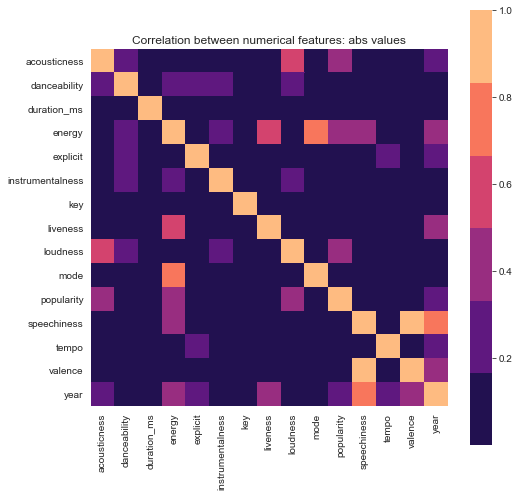

In [22]:
numeric_df = pd.DataFrame(data=pandasDF, columns=numeric_columns, index=pandasDF.index)
corr = np.abs(numeric_df.corr())
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.color_palette("magma")
sns.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between numerical features: abs values')
plt.show()

In [23]:
series = np.abs(corr['popularity']).sort_values(ascending=False)
print('The most linear correlated features to POPULARITY are:')
for i, row in enumerate(series):
    if 0.2 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (abs)')

The most linear correlated features to POPULARITY are:
acousticness      -->  0.41 (abs)
loudness          -->  0.34 (abs)
energy            -->  0.34 (abs)
year              -->  0.27 (abs)


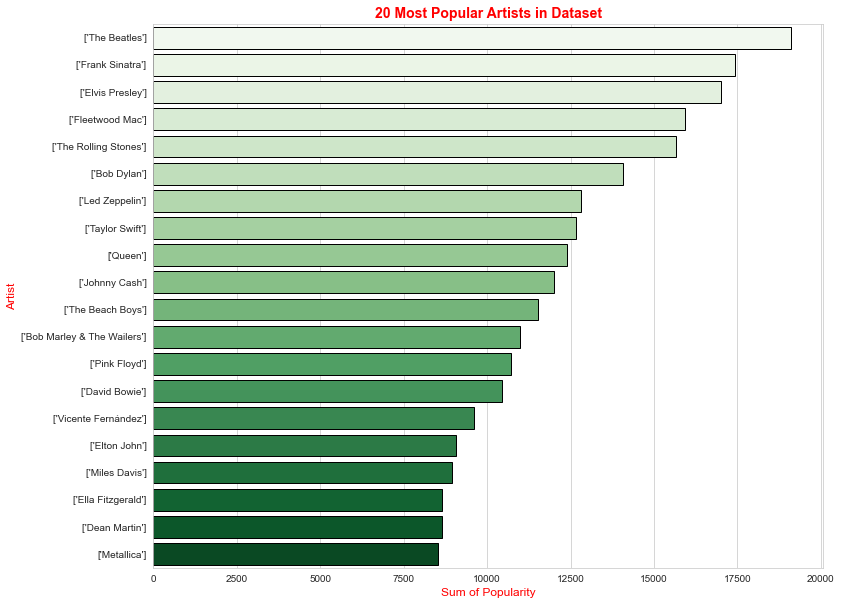

In [24]:
fig, ax = plt.subplots(figsize = (12, 10))
lead_artists = pandasDF.groupby('artists')['popularity'].sum().sort_values(ascending=False).head(20)
ax = sns.barplot(x=lead_artists.values, y=lead_artists.index, palette="Greens", orient="h", edgecolor='black', ax=ax)
ax.set_xlabel('Sum of Popularity', c='r', fontsize=12)
ax.set_ylabel('Artist', c='r', fontsize=12)
ax.set_title('20 Most Popular Artists in Dataset', c='r', fontsize=14, weight = 'bold')
plt.show()

### Select and Standardize Features

In [25]:
# retain these predictors that are most linearly correlated to popularity
vars_to_keep = ["acousticness", "loudness", "energy", "year"]

# subset the dataframe on these predictors
df.select(vars_to_keep)

DataFrame[acousticness: float, loudness: float, energy: float, year: int]

In [26]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["acousticness", "loudness", "energy", "year"],\
                            outputCol = "features")

df = assembler.transform(df.dropna())
df = df.withColumnRenamed("popularity", "label")
df = df.select("label", "features")

df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.97100001573562...|
|    0|[0.99400001764297...|
|    0|[0.99199998378753...|
|    0|[0.99299997091293...|
|    7|[0.91200000047683...|
|    4|[0.98699998855590...|
|    7|[0.99099999666213...|
|    0|[0.99500000476837...|
|    0|[0.99599999189376...|
|    0|[0.98600000143051...|
|    0|[0.76899999380111...|
|    0|[0.99599999189376...|
|    6|[0.88400000333786...|
|   19|[0.86000001430511...|
|   12|[0.91799998283386...|
|    8|[0.82499998807907...|
|   15|[0.16400000452995...|
|   12|[0.17800000309944...|
|   20|[0.84899997711181...|
|    4|[0.83200001716613...|
+-----+--------------------+
only showing top 20 rows



In [27]:
## Feature scaling
# Initialize the `standardScaler`
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(df)

# Transform the data in `df` with the scaler
scaled_df = scaler.transform(df)

In [28]:

# Split data into train set (80%), test set (20%) 
splits = scaled_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

In [29]:
from pyspark.ml.regression import LinearRegression

maxIter=10
regParam=0.3
elasticNetParam=0.8

lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [30]:
model = lr.fit(train_df)

In [31]:
prediction = model.transform(test_df)

In [32]:
prediction.show()

+-----+--------------------+--------------------+------------------+
|label|            features|     features_scaled|        prediction|
+-----+--------------------+--------------------+------------------+
|    0|[0.00156000000424...|[0.00412152960198...| 46.92705847991704|
|    0|[0.00182000000495...|[0.00480845120232...| 46.42542204113113|
|    0|[0.00200999993830...|[0.00531043219435...| 42.06480220613628|
|    0|[0.00411000009626...|[0.01085864552231...| 41.56375882185864|
|    0|[0.01940000057220...|[0.05125492078159...|46.028044233990386|
|    0|[0.19499999284744...|[0.51519117994910...|43.988656451479414|
|    0|[0.24199999868869...|[0.63936548433441...| 7.529771075070244|
|    0|[0.29100000858306...|[0.76882381172393...|13.271653952516886|
|    0|[0.31799998879432...|[0.84015792543604...| 13.64160289976951|
|    0|[0.48699998855590...|[1.28665696380618...| 7.113671198347333|
|    0|[0.58300000429153...|[1.54028959558101...|10.499977126413796|
|    0|[0.67599999904632...|[1.785

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = "label", predictionCol = "prediction",
                          metricName = "rmse")
mse1 = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.5f" % mse1)

MSE: 323.25012
